### 1 VGG16 개념 정리
---
- 구글넷은 인셉션 모듈을 사용(복잡한 구조)
- VGG16은 비교적 간단한 구조, 학술적으로 많이 연구됨
- 16개 계층 중에서 13개가 합성곱 계층이며 3개는 FC 층
- VGG의 특징은 작은 3X3 필터만으로 합성곱 연산을 수행해 더 깊은 구조의 모델을 만듦.

#### AlexNet과 VGG-16 비교
---
- 알렉스 넷은 1,2000,000개 이미지 데이터로 학습
- VGG-16은 14,000,000개 이미지 데이터로 학습,  두배 많은 계층으로 구성

#### AlexNet과 VGG-16 필터 구성 비교
---
- 알렉스넷은 첫번째 합성곱 계층(C1)은 11 x 11 크기의 필터를 사용했고, 두번째 합성곱 계층(C3)는 5 x 5 크기의 필터를 사용
- 알렉스넷은 비교적 큰 크기의 필터를 사용해 수용영역(Receptive Field, RF 즉 커널)을 넓게 확보 -> 전역 특징(Global Features)을 더 효율적으로 학습하지만 가장자리나 모서리와 같은 낮은 수준의 지역 특징(Local Featueres)을 학습하기 어려움

#### VGG- 설계 철학 <<큰 필터를 1번 쓰는 대신 작은 필터를 여러번 쓰면: 같은 범위를 보면서, 파라미터는 줄고 비선성은 늘어남>>
---
- VGG-16은 3 x 3 필터를 여러번 적용해 7 x 7 필터를 대신한다는 뜻
- 수용역역의 관점에서 보면
- 3×3 Conv 1번 필터는 → 주변 3×3만 봄, 3×3 Conv 2번 필터는 → 실질적으로 5×5 범위까지 보고, 3×3 Conv 3번 필터는 → 실질적으로 7×7 범위 
- 더 작은 크기의 필터를 여러번 적용하면 모델의 매개변수의 수가 감소할 뿐만 아니라 활성화 함수를 더 많이 적용해 비선형성이 증가한다는 뜻
- 7 x 7 필터 하나를 사용하면 총 49개의 매개변수가 필요하지만, 3 x 3 필터를 3번 사용하면 총 27( 3x3x3)개의 매개변수만 필요함.

### 2. 모델 구조 및 데이터 시각화

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(), # PIL.Image (파이썬 이미지 라이브러리.Image)를 텐서로 변환 (C, H, W)
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )
}
# ImageFolder("../datasets/pet/train" ) 클래스는
# 경로("../datasets/pet/train")의 하위 폴더 이름들을
# 클래스 이름(y)으로 인식함
train_dataset = ImageFolder("../datasets/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("../datasets/pet/test", transform=hyperparams["transform"])

# ImageFolder가 만든 (x, y) 쌍들을 DataLoader가 batch 단위로 묶어서 꺼내주는 객체
# x → 변환(transform)이 적용된 이미지 텐서
# y → 해당 이미지의 클래스 인덱스 (정수)
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

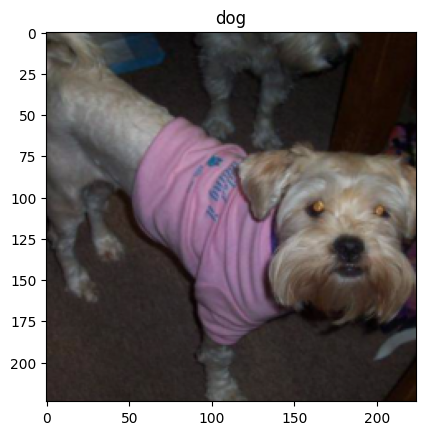

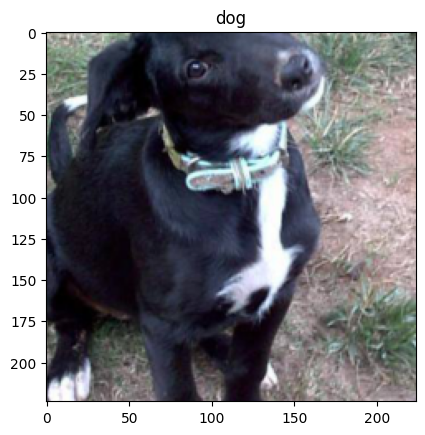

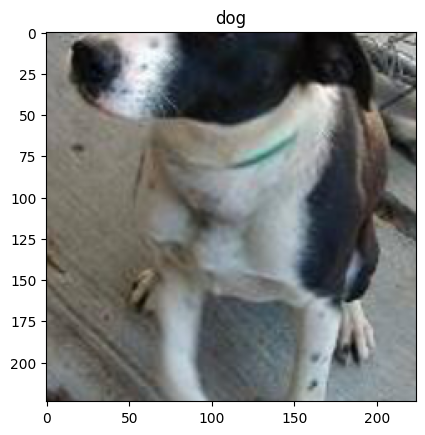

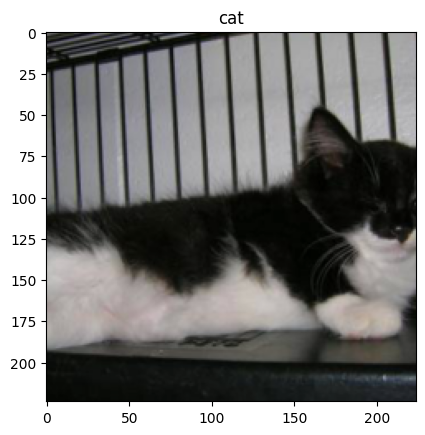

torch.Size([4, 3, 224, 224]) torch.Size([4])


(2001, 8005)

In [3]:
import numpy as np
from matplotlib import pyplot as plt

mean=[0.48235, 0.45882, 0.40784]
std=[0.229, 0.224, 0.225]

# 데이터 로더는 반복자(이터레이터)로 반복가능한(이터러블) 이다.
# iter(train_dataloader) → DataLoader로부터 iterator(반복자)를 하나 만든다
# next(...) → 그 iterator에서 “첫 번째 batch”를 꺼낸다
# 정해진 순서의 첫 batch를 가져온다 (이터레이션)
images, labels = next(iter(train_dataloader))
for image, label in zip(images, labels):
    # image.numpy().transpose((1, 2, 0)) # GPU라면 image.permute(1, 2, 0).cpu().numpy()
    image = image.detach().cpu().permute(1, 2, 0).numpy()
    # 역정규화를 통하여 픽셀 복원
    image = ((std * image + mean) * 255).astype(np.uint8) 

    plt.imshow(image)
    plt.title(train_dataset.classes[int(label)])
    plt.show()
    # break
print(images.shape, labels.shape)
# images는 배치 4장이고, 각 이미지는 (C,H,W) = (3,224,224), y (labels): [batch_size]
len(train_dataloader), len(train_dataset) # drop_last=True

# 폴더로 클래스가 분리된 Dataset이지만, shuffle=True인 DataLoader를 사용하면 
# 배치 출력 순서는 클래스와 무관하게 섞여서(무작위 순서로) 개와 고양이가 나온다.

### 3. 모델 및 데이터 로더 

In [5]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    ),
}

In [7]:
train_dataset = ImageFolder("../datasets/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("../datasets/pet/test", transform=hyperparams["transform"])

train_dataloader = DataLoader(train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True)

In [9]:
# 모델 불러오기
from torchinfo import summary
model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")
# 모델 서머리 파리미터 보기: 1억 3천8백만 개 파라미터 
summary(model)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       147,584
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      295,168
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      590,080
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      590,080
│    └─ReLU: 2-16                        --
│    └─MaxPool2d: 2-17                   --
│    └─Conv2d: 2-18                      1,180,160
│    └─ReLU: 2-19                

In [10]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Conv2d: 2-1 의 커널사이즈(kernel_size)인 경우 총 파라미터는 얼마인가?
 - feature map(커널 수)? = 아웃채널 수 = 64, 
 - 피처 모양 (3=인픗채널, 3, 3) 
 - 커널당 파라미터 수: 가중치 수는 27, 편향 1 커널 1개 = 28,
 - 총 파라미터 수 : 64 x 28 = 1,792

### 출력 크기 구하는 방법
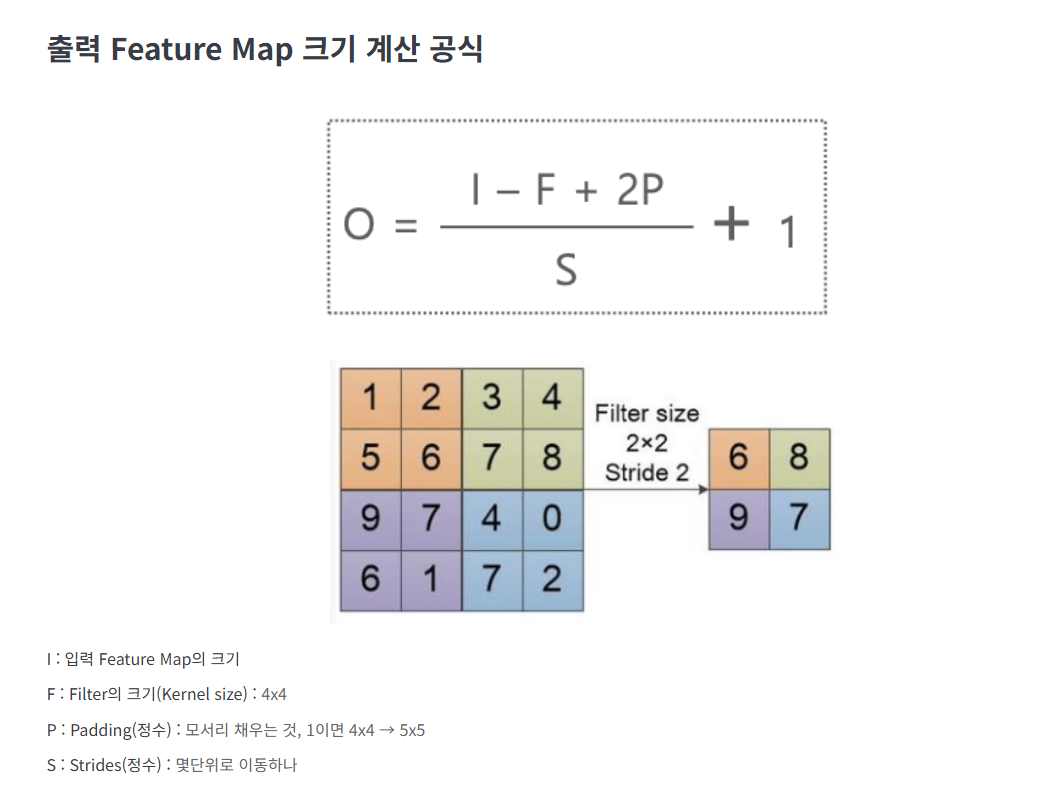

In [14]:
# (6): Linear(in_features=4096, out_features=1000, bias=True)
# 모델마다 분류 헤더의 위치가 다름
# 이피션트넷(v2)는 classifier
"""
classifier =
[0] Dropout
[1] Linear(in_features → num_classes)
임 따라서 
model.classifier[1] = nn.Linear(in_features, num_classes)
"""
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))

In [16]:
print(model)
len(train_dataset.classes)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

2

### 4 모델 학습(미세 조정)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

In [21]:
for epoch in range(hyperparams["epochs"]):
    cost = 0.0

    for images, classes in train_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes) # 미니배치(현재 batch)에 대한 평균 loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss # 현재 배치의 평균 loss를 누적(2001회)한다

    cost = cost / len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

Epoch :    1, Cost : 0.110
Epoch :    2, Cost : 0.040
Epoch :    3, Cost : 0.033
Epoch :    4, Cost : 0.026
Epoch :    5, Cost : 0.021


In [22]:
with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, classes in test_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)

        accuracy += int(torch.eq(classes, outputs_classes).sum())

    print(f"acc@1 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")

acc@1 : 99.01%


In [23]:
torch.save(model.state_dict(), "../models/VGG16.pt")
print("Saved the model weights")

Saved the model weights


### 참고 Dataset를 상속받아 사용하는 방법

In [30]:
# 예제 5, 6 직용 전 - 예제 35 ~ 43 중에서
import torch
import pandas as pd
# import torch.nn as nn
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)
        self.x = df.iloc[:, 0].values
        self.y = df.iloc[:, 1].values
        self.length = len(df)

    def __getitem__(self, index):
        x = torch.FloatTensor([self.x[index] ** 2, self.x[index]])
        y = torch.FloatTensor([self.y[index]])
        return x, y

    def __len__(self):
        return self.length

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(2, 1)

    def forward(self, x):
        x = self.layer(x)
        return x

In [32]:
from torch.utils.data import random_split

# 전체 데이터셋
full_dataset = CustomDataset('../datasets/non_linear.csv')

# 비율
total_len = len(full_dataset)
train_len = int(total_len * 0.8)
val_len   = int(total_len * 0.1)
test_len  = total_len - train_len - val_len

# 랜덤 분할 (재현성 원하면 generator에 seed)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

In [34]:
train_dataloader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, drop_last=False # 128을 32로 바꿈 True
)

val_dataloader = DataLoader(
    val_dataset, batch_size=32, shuffle=False
)

test_dataloader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)
## 교재대로하면 128만 쓰고,32개는 사실상 버려짐. 20, 20개만 쓰임. 
## 그래서 batch_size를 줄이고 drop_last=False로 바꿈, default는 False 이므로 validation 과 test 데이터로더에서는 drop_lsat를 뺐음

In [36]:
train_used = len(train_dataloader) * train_dataloader.batch_size
val_used   = len(val_dataloader)   * val_dataloader.batch_size
test_used  = len(test_dataloader)  * test_dataloader.batch_size

# 데이터 개수 확인
print(f"Train dataset samples: {len(train_dataset)}")
print(f"Val dataset samples  : {len(val_dataset)}")
print(f"Test dataset samples : {len(test_dataset)}")

print(f"Total samples        : {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

Train dataset samples: 160
Val dataset samples  : 20
Test dataset samples : 20
Total samples        : 200


In [38]:
# 학습 및 검증
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CustomModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

for epoch in range(10000):
    model.train()
    cost = 0.0

    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y) # criterion = nn.MSELoss() -> 배치당 평균 S.E

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss.detach()

    cost = cost / len(train_dataloader)

    # 🔹 검증(loss는 data_loss만!)
    if (epoch + 1) % 1000 == 0:
        model.eval()
        val_cost = 0.0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss = criterion(val_output, y_val)
                val_cost += val_loss

        val_cost = val_cost / len(val_dataloader)

        print(
            f"Epoch {epoch+1:4d} | "
            f"train_loss: {cost.item():.3f} | "
            f"val_loss: {val_cost.item():.3f}"
        )


Epoch 1000 | train_loss: 0.074 | val_loss: 0.082
Epoch 2000 | train_loss: 0.074 | val_loss: 0.082
Epoch 3000 | train_loss: 0.073 | val_loss: 0.079
Epoch 4000 | train_loss: 0.074 | val_loss: 0.079
Epoch 5000 | train_loss: 0.075 | val_loss: 0.077
Epoch 6000 | train_loss: 0.073 | val_loss: 0.079
Epoch 7000 | train_loss: 0.074 | val_loss: 0.081
Epoch 8000 | train_loss: 0.073 | val_loss: 0.078
Epoch 9000 | train_loss: 0.073 | val_loss: 0.079
Epoch 10000 | train_loss: 0.073 | val_loss: 0.079
